# Business Understanding

# Data Understanding

In [37]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from yellowbrick.model_selection import feature_importances

In [38]:
pd.set_option('display.max_columns',999)

In [39]:
df = pd.read_csv("covtype.csv")

In [40]:
df= df.apply(lambda x: x.sample(n=100000, replace = True, random_state = 1))

In [41]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
128037,2771,27,11,0,0,1880,215,217,137,2089,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
491755,2889,64,9,218,84,685,229,221,125,930,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
470924,3095,84,7,0,0,1167,230,228,131,2140,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
491263,3075,140,14,240,-6,866,240,235,122,1237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
371403,3288,353,13,417,77,3439,196,216,157,2698,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [42]:
df.reset_index(drop=True,inplace=True)

In [43]:
df.shape

(100000, 55)

In [44]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2960.503820,156.034500,14.09028,269.46504,46.577100,2356.821130,212.102240,223.450730,142.731840,1976.750600,0.448260,0.052070,0.436820,0.062850,0.005110,0.013210,0.008190,0.021030,0.002830,0.011460,0.0001,0.000230,0.001970,0.055920,0.020920,0.050340,0.030820,0.000870,0.0,0.005110,0.005940,0.003470,0.007140,0.015920,0.001420,0.058280,0.099710,0.035690,0.000870,0.004490,0.001990,0.001630,0.198840,0.051700,0.044320,0.09191,0.077430,0.002620,0.003300,0.00021,0.000460,0.025740,0.023680,0.015130,2.043550
std,279.781093,111.834835,7.49341,211.79849,58.301387,1559.597647,26.723596,19.748727,38.306991,1317.725934,0.497318,0.222169,0.495995,0.242694,0.071302,0.114174,0.090128,0.143485,0.053123,0.106437,0.0100,0.015164,0.044341,0.229768,0.143117,0.218647,0.172831,0.029483,0.0,0.071302,0.076843,0.058805,0.084197,0.125167,0.037656,0.234273,0.299614,0.185517,0.029483,0.066857,0.044565,0.040341,0.399129,0.221422,0.205806,0.28890,0.267274,0.051119,0.057351,0.01449,0.021443,0.158359,0.152051,0.122071,1.387045
min,1866.000000,0.000000,0.00000,0.00000,-163.000000,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2811.000000,59.000000,9.00000,108.00000,7.000000,1110.000000,198.000000,213.000000,119.000000,1022.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2998.000000,128.000000,13.00000,218.00000,30.000000,2010.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
Elevation                             100000 non-null int64
Aspect                                100000 non-null int64
Slope                                 100000 non-null int64
Horizontal_Distance_To_Hydrology      100000 non-null int64
Vertical_Distance_To_Hydrology        100000 non-null int64
Horizontal_Distance_To_Roadways       100000 non-null int64
Hillshade_9am                         100000 non-null int64
Hillshade_Noon                        100000 non-null int64
Hillshade_3pm                         100000 non-null int64
Horizontal_Distance_To_Fire_Points    100000 non-null int64
Wilderness_Area1                      100000 non-null int64
Wilderness_Area2                      100000 non-null int64
Wilderness_Area3                      100000 non-null int64
Wilderness_Area4                      100000 non-null int64
Soil_Type1                            100000 non-n

In [46]:
# df.hist(bins=20,figsize=(36,36))
# plt.show()

# Data Preparation

In [47]:
df['Pine'] = df.Cover_Type.apply(lambda x: 1 if x == 2 else 0)

In [48]:
df.drop(["Cover_Type"],axis=1,inplace=True)

In [49]:
cat_columns = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
               'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
               'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
               'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
               'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
               'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
               'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
               'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
               'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
               'Soil_Type39', 'Soil_Type40', 'Wilderness_Area1',
               'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4','Pine']

In [50]:
num_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points']

In [51]:
scaler = StandardScaler()

In [52]:
df_num_s = pd.DataFrame(scaler.fit_transform(df[num_columns]))

In [53]:
df_num_s.columns = df[num_columns].columns

In [54]:
df_plus_wild_s = pd.concat([df_num_s,df[cat_columns]],axis=1)

In [55]:
df_plus_wild_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Pine
0,-0.677332,-1.153801,-0.412402,-1.272277,-0.798906,-0.305735,0.108435,-0.326642,-0.149630,0.085185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,-0.255572,-0.822954,-0.679304,-0.242992,0.641890,-1.071962,0.632319,-0.124096,-0.462890,-0.794365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.480722,-0.644118,-0.946207,-1.272277,-0.798906,-0.762906,0.669740,0.230359,-0.306260,0.123888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.409237,-0.143377,-0.012048,-0.139119,-0.901820,-0.955906,1.043943,0.584814,-0.541205,-0.561387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,1.170550,1.761227,-0.145499,0.696585,0.521824,0.693887,-0.602551,-0.377278,0.372471,0.547347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [56]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Pine
0,2771,27,11,0,0,1880,215,217,137,2089,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2889,64,9,218,84,685,229,221,125,930,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3095,84,7,0,0,1167,230,228,131,2140,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3075,140,14,240,-6,866,240,235,122,1237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3288,353,13,417,77,3439,196,216,157,2698,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [57]:
X_plus_wild = df.drop('Pine',1)
X_plus_wild_s = df_plus_wild_s.drop('Pine',1)
X = X_plus_wild.drop(['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'],axis=1)
X_s = X_plus_wild_s.drop(['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'],axis=1)

y = df["Pine"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=.25,random_state=42)


In [59]:
X_train_s, X_test_S, y_train, y_test = train_test_split(X_s,y,test_size=.25,random_state=42)

X_train_s, X_val_s, y_train, y_val = train_test_split(X_train_s,y_train,test_size=.25,random_state=42) 


In [60]:
X_plus_wild_train, X_plus_wild_test, y_train, y_test = train_test_split(X_plus_wild,y,test_size=.25,random_state=42)

X_plus_wild_train, X_plus_wild_val, y_train, y_val = train_test_split(X_plus_wild_train,y_train,test_size=.25,random_state=42)


In [61]:
X_plus_wild_train_s, X_plus_wild_test_s, y_train, y_test = train_test_split(X_plus_wild_s,y,test_size=.25,random_state=42)

X_plus_wild_train_s, X_plus_wild_val_s, y_train, y_val = train_test_split(X_plus_wild_train_s,y_train,test_size=.25,random_state=42)


In [62]:
X_plus_wild_train_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
97274,-2.789709,0.840221,0.254855,-0.375194,-0.078508,-1.066832,-1.089015,1.344360,1.599407,-0.307160,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
80546,1.027581,1.761227,1.856270,1.957224,1.465202,-0.676345,-1.874841,-2.200190,0.137525,-0.328409,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
92139,-2.510918,-1.064383,2.123172,-0.988988,-0.575926,-1.434237,-0.303188,-3.162282,-1.794246,-0.836104,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
26663,-0.037543,-0.688827,-1.213109,0.073348,-0.953277,-0.814202,0.520058,0.382268,-0.097420,0.139824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
45662,0.566504,-1.234277,-0.812756,-0.988988,-0.695992,2.832270,0.108435,0.027813,0.085315,0.387980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [63]:
X_train_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
97274,-2.789709,0.840221,0.254855,-0.375194,-0.078508,-1.066832,-1.089015,1.344360,1.599407,-0.307160,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80546,1.027581,1.761227,1.856270,1.957224,1.465202,-0.676345,-1.874841,-2.200190,0.137525,-0.328409,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
92139,-2.510918,-1.064383,2.123172,-0.988988,-0.575926,-1.434237,-0.303188,-3.162282,-1.794246,-0.836104,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26663,-0.037543,-0.688827,-1.213109,0.073348,-0.953277,-0.814202,0.520058,0.382268,-0.097420,0.139824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45662,0.566504,-1.234277,-0.812756,-0.988988,-0.695992,2.832270,0.108435,0.027813,0.085315,0.387980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modelling

In [64]:
skf = StratifiedKFold(n_splits=5,random_state=42)

In [65]:
#===============================================================================================#

# Classification Models Class

#===============================================================================================#

class Classification():
    def __init__(self,model_type,x_train,x_val,y_train,y_val):
        self.model_type = model_type
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        self.feature_importances = pd.DataFrame()
        self.name = self
        
        if self.model_type == 'Logistic Regression':
            self.technique = LogisticRegression(fit_intercept=False)
        elif self.model_type == 'Decision Tree':
            self.technique = DecisionTreeClassifier(random_state=42)
        elif self.model_type == 'Random Forest':
            self.technique = RandomForestClassifier(n_estimators=20,n_jobs=-1,random_state=42)
        elif self.model_type == "SVM":
            self.technique = SVC()
                
#===============================================================================================#

# Score Function

#===============================================================================================#

    def scores(self,model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]

        val_prob = model.predict_proba(X_val)[:,1]

        auc_train = round(roc_auc_score(y_train,train_prob),4)
        auc_val = round(roc_auc_score(y_val,val_prob),4)
        
        self.auc_train = auc_train
        self.auc_val = auc_val
        
        d = {'Model Name': [self.model_type], 'Train AUC': [self.auc_train], 'Validation AUC': [self.auc_val]}
        self.scores_table = pd.DataFrame(data=d)
#         self.scores_table(index=self)
#         self.scores_table["Model Name"] = [self.model_type]
#         self.scores_table["Train AUC"] = [self.auc_train]
#         self.scores_table["Validation AUC"] = [self.auc_val]

        
        return self.scores_table
        
#===============================================================================================#

# Threshold Annotation Function

#===============================================================================================#

    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k % 500 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
        
#===============================================================================================#

# ROC Plot Function

#===============================================================================================#
     
    def roc_plot(self,model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        self.threshold_df = pd.DataFrame()
        for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
            fpr, tpr, threshold = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        self.fpr = fpr
        self.tpr = tpr
        self.thr = threshold
        self.threshold_df["Threshold"] = self.thr
        self.threshold_df["TPR"] = self.tpr
        self.threshold_df["FPR"] = self.fpr
        Classification.annot(fpr, tpr, threshold)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()

#===============================================================================================#

# Get Scores Function -> Outputs a DataFrame with optimum AUC scores and R^2 scores, and a ROC Plot

#===============================================================================================#

    def get_scores(self,param_grid,cv_type):
        reg = self.technique
        fit_reg = reg.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,self.best_model,self.x_train,self.x_val,self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        if param_grid == {}:
            pass
        else:
            print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self,self.best_model,self.x_train,self.x_val,self.y_train,self.y_val)
        self.y_tested = self.best_model.predict(self.x_val)
        

#===============================================================================================#

# Optimum Plot Function

#===============================================================================================#

    def opt_plots(self):
        if self.model_type == "Decision Tree" or self.model_type == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params,opt[cols]],axis=1,sort=False)

            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
        else:
            print("This model does not have an optimum hyperparameter plot!")
        
#===============================================================================================#

# Confusion Matrix Function

#===============================================================================================#

    def conf_matrix(self,y_true, y_pred):
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        for ind, label in enumerate(y_true):
            pred = y_pred[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
            self.cm_values = cm
        return cm
    
#===============================================================================================#

# Display Confusion Matrix Table Function

#===============================================================================================#
    
    def show_conf_matrix(self):
        Classification.conf_matrix(self,self.y_val,self.y_tested)
        cnf_matrix = confusion_matrix(self.y_val,self.y_tested)
        self.cnf_matrix = cnf_matrix

        plt.figure(figsize=(7,7))
        plt.imshow(cnf_matrix,  cmap=plt.cm.Reds) 

        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center',fontsize=25)
        plt.grid(False)
        plt.colorbar
        
#===============================================================================================#

# Plot Decision Tree Function

#===============================================================================================#

    def plot_decision_tree(self):
        if self.model_type == "Decision Tree":
            dot_data = StringIO()
            export_graphviz(self.best_model, out_file=dot_data,  
                            filled=True, rounded=True,
                            special_characters=True)
            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            
            graph.write_png(f'{self.model_type}.png')
            
            img = mpimg.imread(f'{self.model_type}.png')
            plt.figure(figsize=(40,50))
            plt.imshow(img)
            plt.show()  
        
        else:
            print("This model does not have a decision tree plot!")
            
#===============================================================================================#

# Feature Importance Function

#===============================================================================================#
   
    def get_feature_importances(self):
        self.feature_importances = pd.DataFrame(self.best_model.feature_importances_,
                                                index = self.x_train.columns,
                                                columns=['Importance']).sort_values('Importance',ascending =False)
        return self.feature_importances
       

## Baseline Model (Logistic Regression)

### Baseline Model Including Wilderness Areas

In [66]:
baseline_plus_wild = Classification('Logistic Regression',X_plus_wild_train_s,X_plus_wild_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8243,0.8247


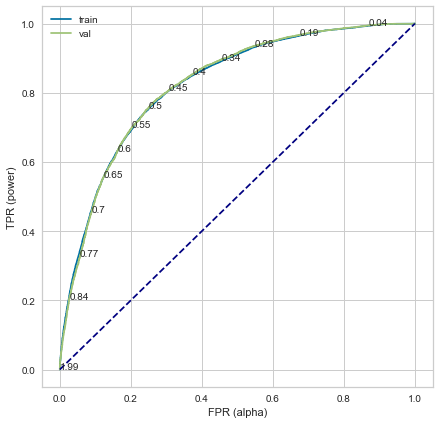

In [67]:
param_grid = {}
baseline_plus_wild.get_scores(param_grid,skf)

### Baseline Model

In [68]:
baseline = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8002,0.7983


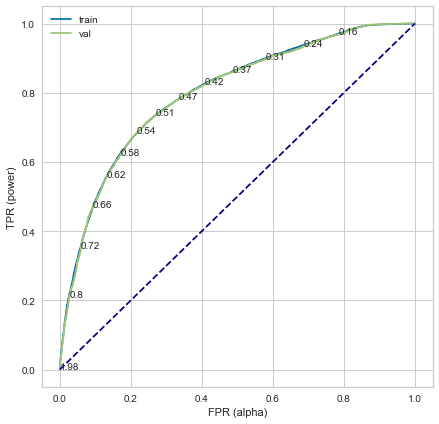

In [69]:
param_grid = {}
baseline.get_scores(param_grid,skf)

## Hyperparameter Tuning Logistic Regression

### Logistic Classifier Optimisation 1st Attempt

In [70]:
logistic1 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7987


The best hyperparameters are:  {'C': 1000, 'penalty': 'l2'} 



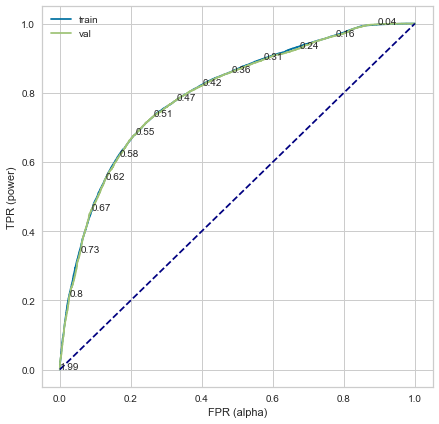

In [71]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[0.01,0.1,1,10,100,1000,10000]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic1.get_scores(param_grid,skf)

### Logistic Classifier Optimisation 2nd Attempt

In [72]:
logistic2 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7986


The best hyperparameters are:  {'C': 600, 'penalty': 'l2'} 



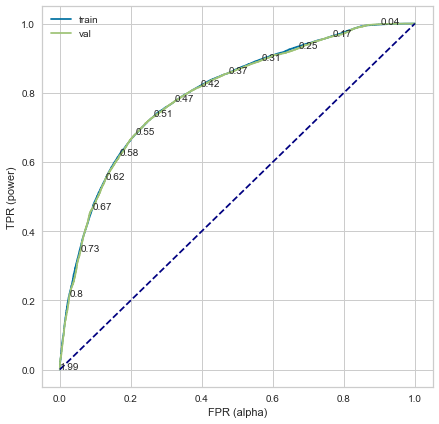

In [73]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[400,600,1000,2000,3000,4000,5000]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic2.get_scores(param_grid,skf)


### Logistic Classifier Optimisation 3rd Attempt

In [74]:
logistic3 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7986


The best hyperparameters are:  {'C': 600, 'penalty': 'l2'} 



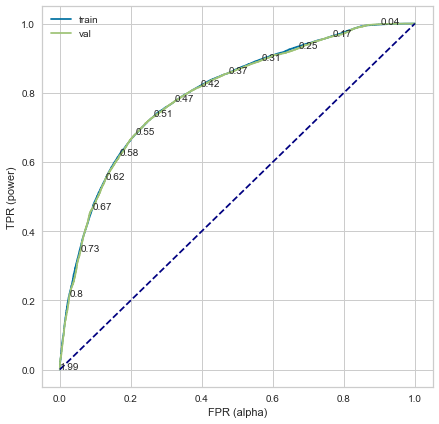

In [75]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[500,550,600,650,700,750,800]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic3.get_scores(param_grid,skf)

### Logistic Classifier Optimisation 4th Attempt

In [76]:
logistic4 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7987


The best hyperparameters are:  {'C': 610, 'penalty': 'l2'} 



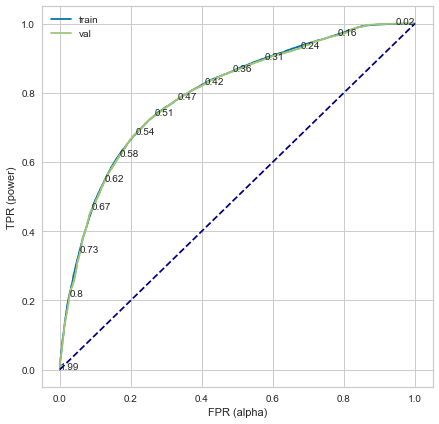

In [77]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[580,590,600,610,620,630]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic4.get_scores(param_grid,skf)

## Hyperparameter Tuning Decision Tree

### Decision Tree Optimisation 1st Attempt

In [78]:
dtree1 = Classification('Decision Tree',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.9762,0.9094


The best hyperparameters are:  {'max_depth': 35, 'min_samples_leaf': 10} 



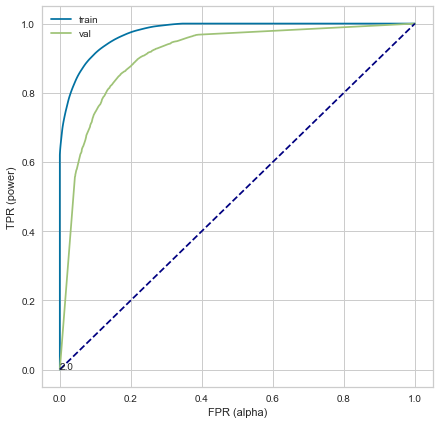

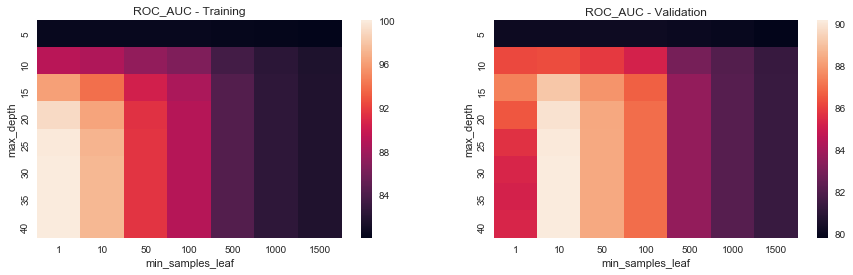

In [79]:
param_grid = {'max_depth':[5,10,15,20,25,30,35,40],            # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]}  # The minimum number of samples required to be at a leaf node

dtree1.get_scores(param_grid,skf)
dtree1.opt_plots()

### Decision Tree Optimisation 2nd Attempt

In [80]:
dtree2 = Classification('Decision Tree',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.9762,0.9094


The best hyperparameters are:  {'max_depth': 33, 'min_samples_leaf': 10} 



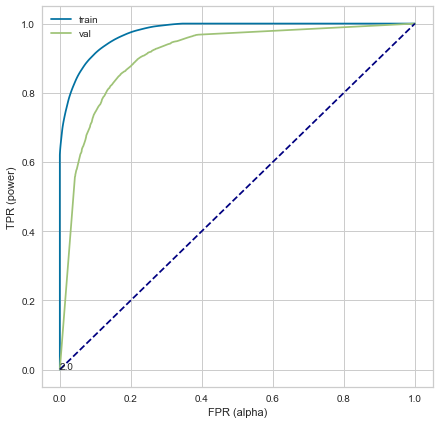

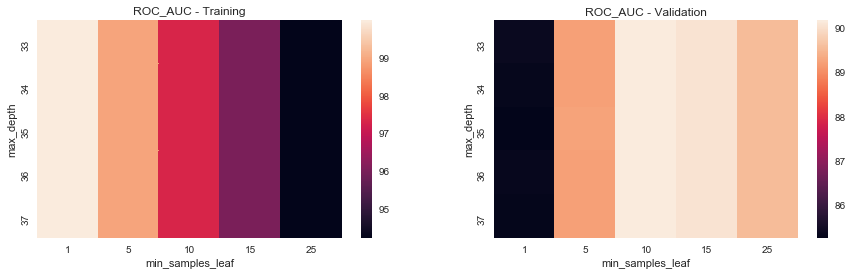

In [81]:
param_grid = {'max_depth':[33,34,35,36,37],         # The maximum depth of the tree
              'min_samples_leaf':[1,5,10,15,25]}  # The minimum number of samples required to be at a leaf node

dtree2.get_scores(param_grid,skf)
dtree2.opt_plots()

### Decision Tree Optimisation 3rd Attempt

In [82]:
dtree3 = Classification('Decision Tree',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.9762,0.9094


The best hyperparameters are:  {'max_depth': 33, 'min_samples_leaf': 10} 



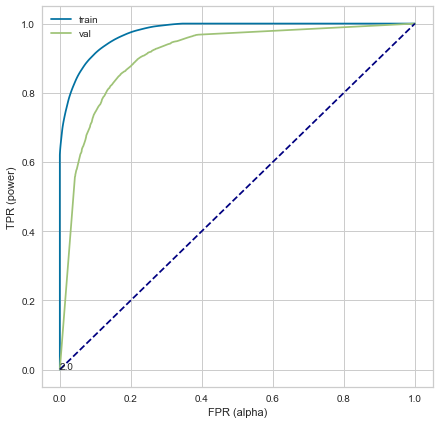

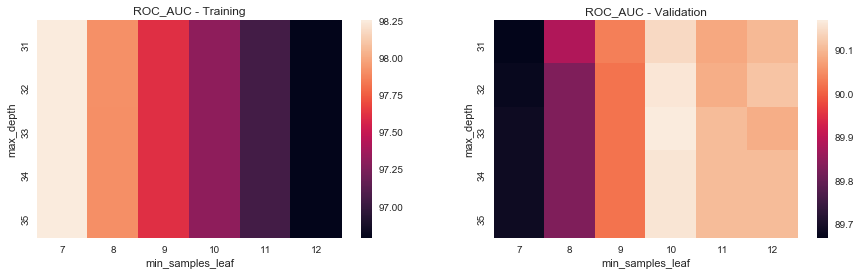

In [83]:
param_grid = {'max_depth':[31,32,33,34,35],         # The maximum depth of the tree
              'min_samples_leaf':[7,8,9,10,11,12]}  # The minimum number of samples required to be at a leaf node

dtree3.get_scores(param_grid,skf)
dtree3.opt_plots()

## Hyperparameter Tuning Random Forest

### Random Forest Optimisation 1st Attempt

In [84]:
ran_forest1 = Classification('Random Forest',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Random Forest,1.0,0.9617


The best hyperparameters are:  {'max_depth': 40, 'min_samples_leaf': 1} 



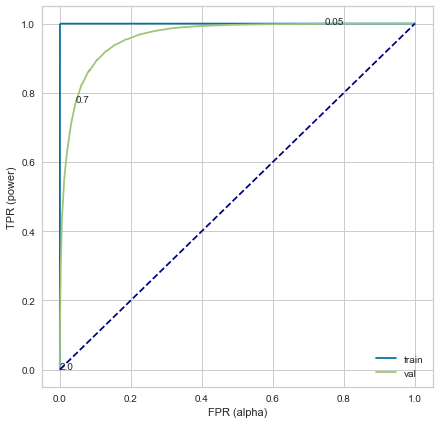

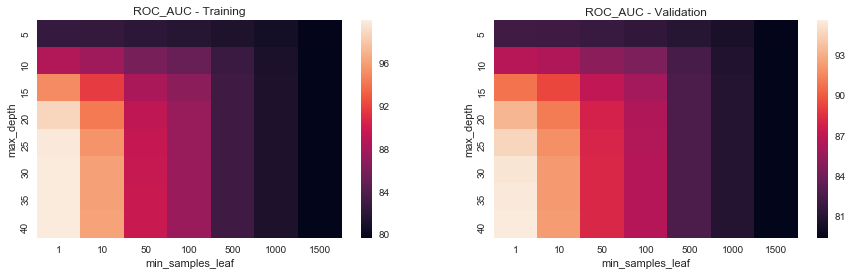

In [85]:
param_grid = {'max_depth':[5,10,15,20,25,30,35,40],           # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]} # The minimum number of samples required to be at a leaf node

ran_forest1.get_scores(param_grid,skf)
ran_forest1.opt_plots()

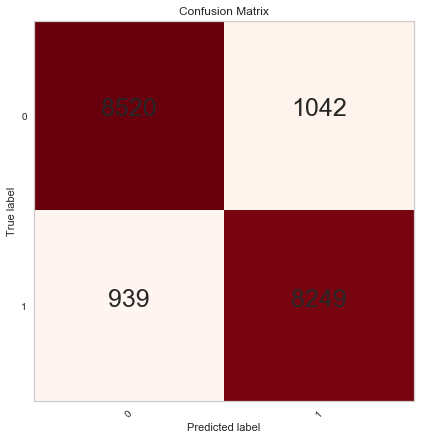

In [86]:
ran_forest1.show_conf_matrix()

### Random Forest Optimisation 2nd Attempt

In [87]:
ran_forest2 = Classification('Random Forest',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Random Forest,1.0,0.9622


The best hyperparameters are:  {'max_depth': 43, 'min_samples_leaf': 1} 



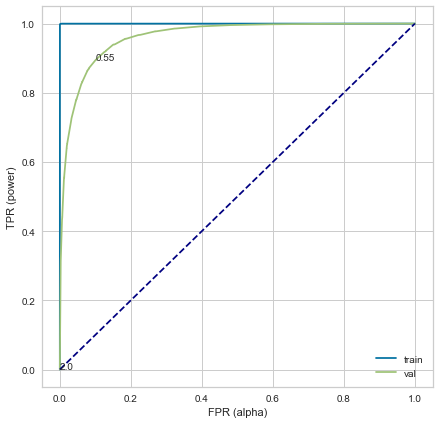

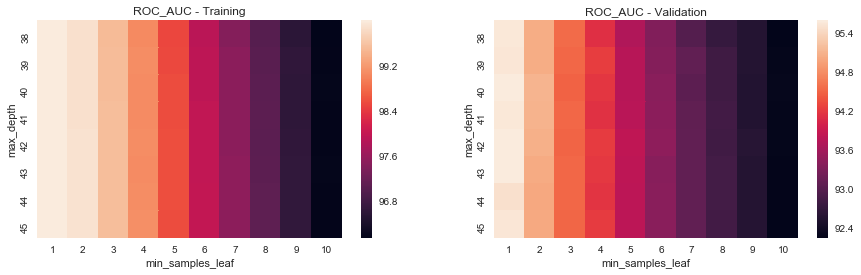

In [88]:
param_grid = {'max_depth':[38,39,40,41,42,43,44,45],           # The maximum depth of the tree
              'min_samples_leaf':range(1,10+1)}                                              # The minimum number of samples required to be at a leaf node

ran_forest2.get_scores(param_grid,skf)
ran_forest2.opt_plots()

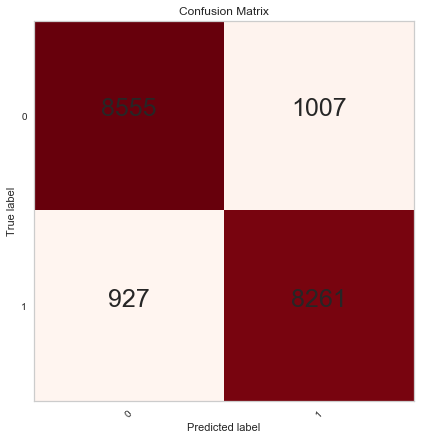

In [89]:
ran_forest2.show_conf_matrix()

## Hyperparameter Tuning Support Vector Machines

### SVC Optimisation 1st Attempt

In [90]:
svm1 = Classification('SVM',X_train_s,X_val_s,y_train,y_val)

In [91]:
# param_grid = {}       

# svm1.get_scores(param_grid,skf)

SVM is not suitable for large datasets because of its high training time.

## Ensemble

In [92]:
#===============================================================================================#

# Classification Models Class

#===============================================================================================#

class Ensemble(Classification):
    
    def __init__(self, ensemble_method, estimators, X_train, X_val, y_train, y_val):
        
        self.ensemble_method = ensemble_method
        self.x_train = X_train
        self.y_train = y_train
        self.x_val = X_val
        self.y_val = y_val
        self.model_type = ensemble_method
        self.scores_table = pd.DataFrame()
        
        if self.ensemble_method == "Voting":
            self.technique = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
        elif self.ensemble_method == "AdaBoost":
            self.technique = AdaBoostClassifier(estimators, algorithm='SAMME', n_estimators=20)
        elif self.ensemble_method == "XGBoost":
            self.technique = XGBClassifier(n_jobs=-1)
        elif self.ensemble_method == "Stacking":
            self.technique = StackingClassifier(estimators)
            

## AdaBoost Classifier

### AdaBoost Applied to Logistic Regression

In [93]:
estimators = logistic4.best_model
adaboost_log_reg = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,AdaBoost,0.6534,0.6528


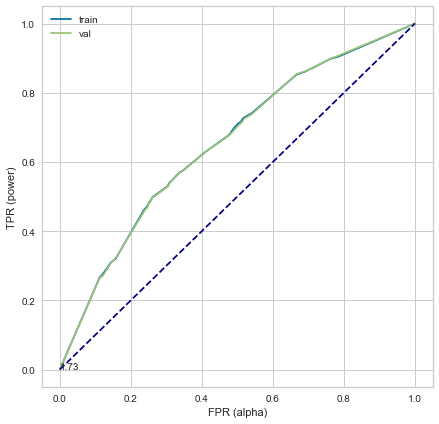

In [94]:
adaboost_log_reg.get_scores({}, skf)

### AdaBoost Applied to Decision Tree

In [95]:
estimators = dtree3.best_model
adaboost_dtree = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,AdaBoost,1.0,0.9709


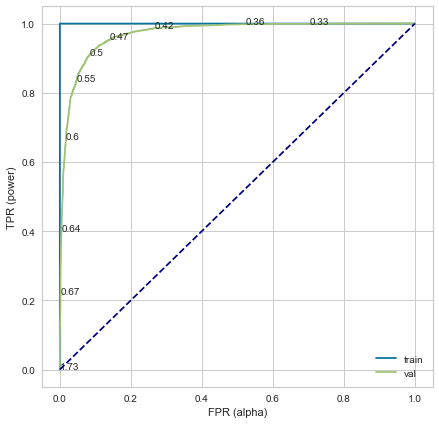

In [96]:
adaboost_dtree.get_scores({}, skf)

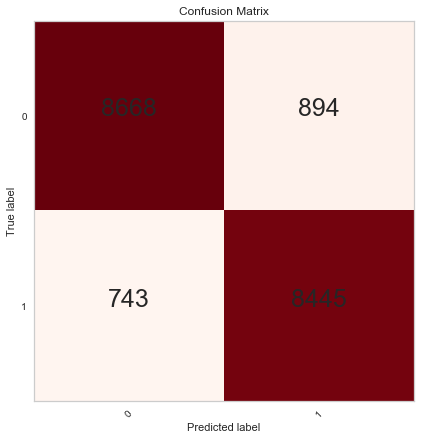

In [97]:
adaboost_dtree.show_conf_matrix()

### AdaBoost Applied to Random Forest

In [98]:
estimators = ran_forest2.best_model
adaboost_ran_forest = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,AdaBoost,1.0,0.9175


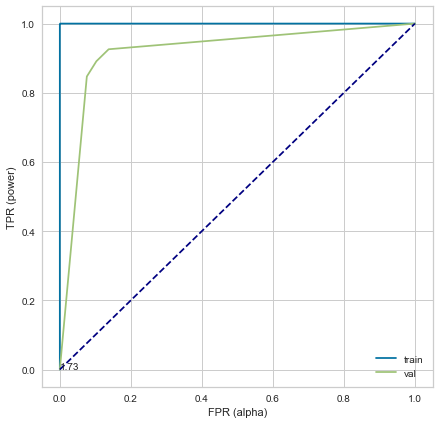

In [99]:
adaboost_ran_forest.get_scores({}, skf)

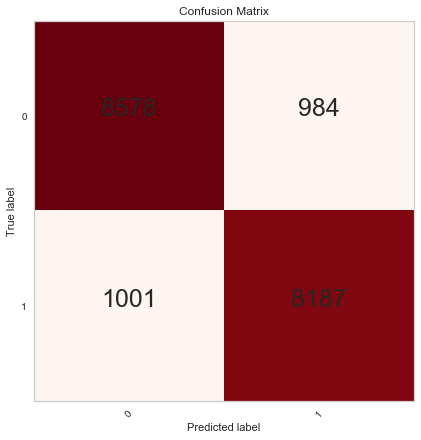

In [100]:
adaboost_ran_forest.show_conf_matrix()

## XGBoost Classifier

In [101]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,XGBoost,0.962,0.9378


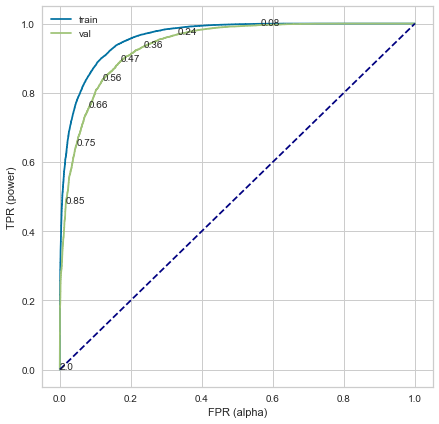

In [102]:
xgboost.get_scores({}, skf)

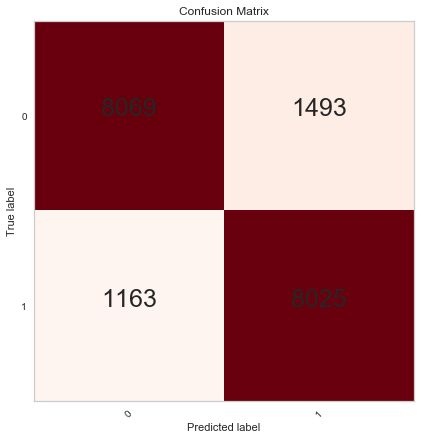

In [103]:
xgboost.show_conf_matrix()

## Voting Classifier

In [104]:
dtree_best = ('ada_dtree', adaboost_dtree.best_model)
rand_forest = ('rnd', ran_forest2.best_model)
estimators = [dtree_best,rand_forest]

In [105]:
voting = Ensemble("Voting", estimators, X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Voting,1.0,0.9704


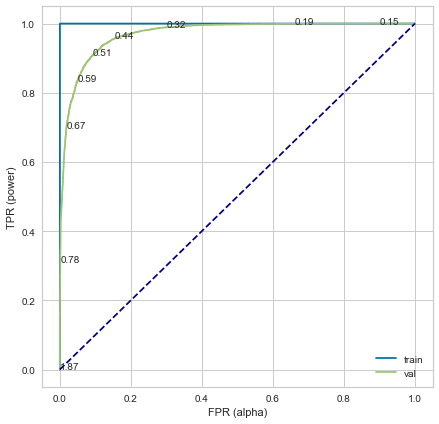

In [106]:
voting.get_scores({}, skf)

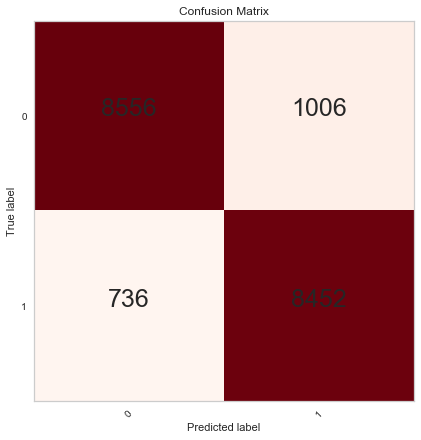

In [107]:
voting.show_conf_matrix()

## Stacking Classifier

In [108]:
dtree_best = ('ada_dtree', adaboost_dtree.best_model)
rand_forest = ('rnd', ran_forest2.best_model)
estimators = [dtree_best,rand_forest]
stacking = Ensemble("Stacking", estimators, X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Stacking,1.0,0.9745


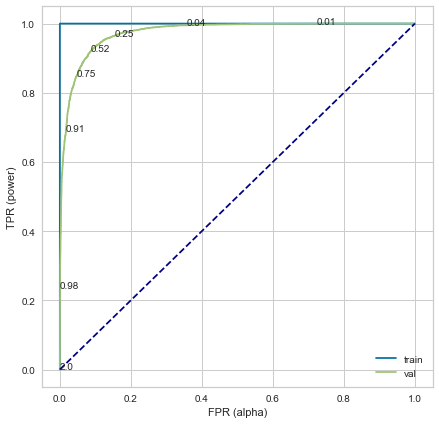

In [109]:
stacking.get_scores({}, skf)

## Model Selection

In [110]:
all_models = pd.concat([baseline.scores_table,
                       logistic4.scores_table,
                       dtree3.scores_table,
                       ran_forest2.scores_table,
                       adaboost_log_reg.scores_table,
                       adaboost_dtree.scores_table,
                       adaboost_ran_forest.scores_table,
                       xgboost.scores_table,
                       voting.scores_table,
                       stacking.scores_table],
                       axis=0)

In [111]:
all_models

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8002,0.7983
0,Logistic Regression,0.8007,0.7987
0,Decision Tree,0.9762,0.9094
0,Random Forest,1.0000,0.9622
0,AdaBoost,0.6534,0.6528
0,AdaBoost,1.0000,0.9709
0,AdaBoost,1.0000,0.9175
0,XGBoost,0.9620,0.9378
0,Voting,1.0000,0.9704
0,Stacking,1.0000,0.9745


## Threshold Selection

In [177]:
def threshold_calculator(cm_values,threshold_df):
    TP = cm_values['TP']
    FP = cm_values['FP']
    TN = cm_values['TN']
    FN = cm_values['FN']
    Prevalance = (TP + FP)/(TP+FP+TN+FN)
    CTP = -100
    CFP = 200
    CTN = 0
    CFN = 0
    m = ((1-Prevalance)/Prevalance) * ( (CFP - CTN) / (CFN - CTP) )
    for i,row in threshold_df.iterrows():
        fm = row.TPR - (m*(row.FPR))
        row["fm"] = fm
    return threshold_df.sort_values(by='fm',ascending=False).head()

In [178]:
threshold_calculator(adaboost_dtree.cm_values,adaboost_dtree.threshold_df)

,Threshold,TPR,FPR,fm
2103,0.529439,0.856008,0.052499,0.750199
2101,0.529698,0.855681,0.052395,0.750084
2081,0.543100,0.852852,0.051035,0.749994
2088,0.531953,0.853831,0.051558,0.749920
2083,0.542168,0.853178,0.051245,0.749899


## Testing Model

# Evaluation

## Feature Importances

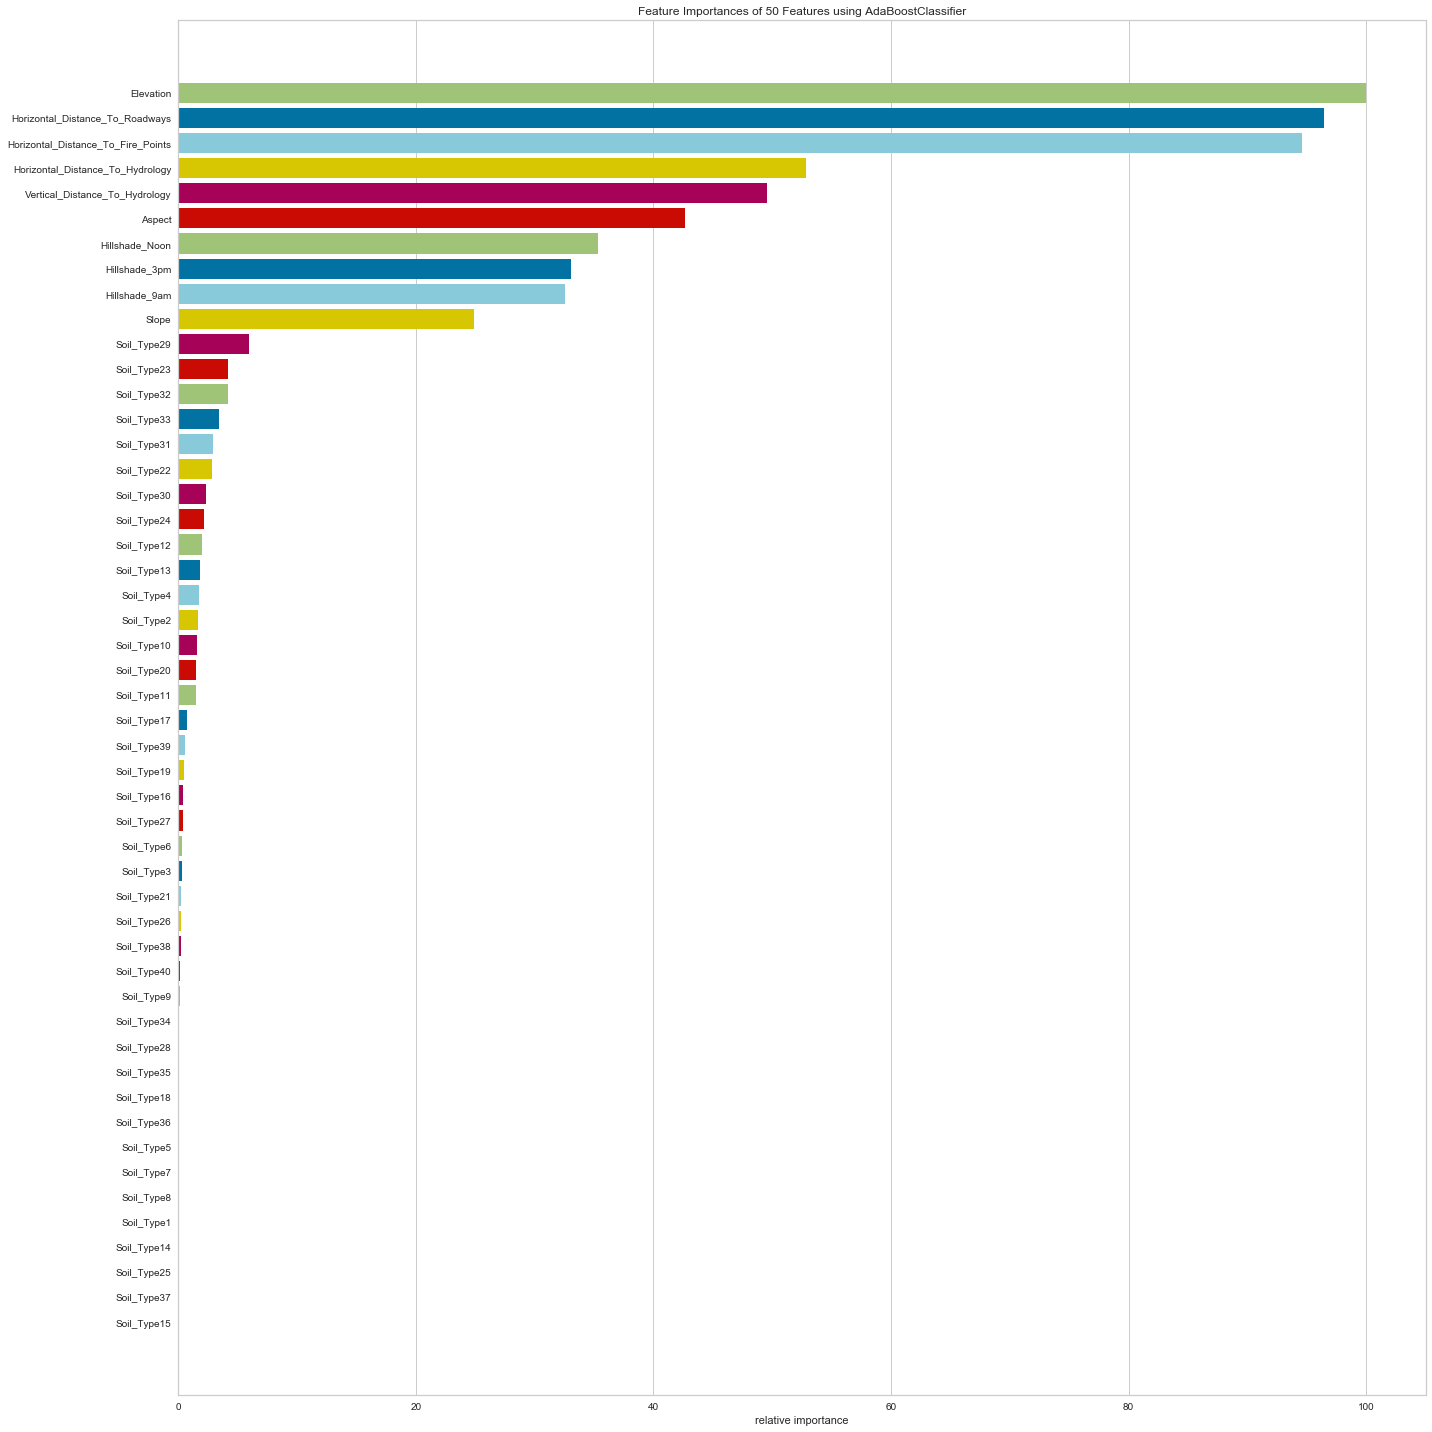

<Figure size 432x288 with 0 Axes>

In [118]:
plt.figure(figsize=(20,20))
feature_importances(adaboost_dtree.best_model, X_train, y_train)
plt.savefig('./bestmodel_feature_importance.png')
plt.show()